In [22]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm, stability_index_lorenz63
from model import M63 as M
from assimilation import OI, ExtendedKF, EnKF, M3DVar

In [3]:
X_nature = np.load('./data/X_nature.npy')
X_ini = np.load('./data/X_ini.npy')
ts = np.load('./data/time_span.npy')
Pb = np.load('./data/Pb.npy')
R = np.load('./data/R.npy')

In [4]:
dt = 0.01

In [17]:
def RMSE(forecast, nature):
    return np.sqrt(np.mean((forecast-nature)**2, axis=0))

# Assimilate normal observation

#### `rmse_ekf` as CNTL in the later experiments

In [5]:
# normal observation
X_obs = np.load('./data/obs_normal.npy')

In [7]:
ekf = ExtendedKF(lorenz63_fdm, dt)
ekf.list_params()
params = {
    'X_ini': X_ini,
    'obs': X_obs,
    'obs_interv': 8,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(3),
    'M': lambda X: M(X.ravel(), dt),
    'alpha': 0.3,
    'inflat': 1.4
}
ekf.set_params(**params)
ekf.cycle()

0.9408792138195026


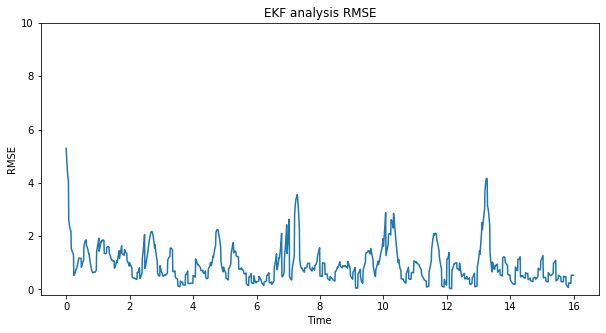

In [9]:
rmse_ekf = RMSE(ekf.analysis, X_nature)

plt.figure(figsize=(10, 5))
plt.plot(ts, rmse_ekf)
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.ylim([-0.2, 10])
plt.title('EKF analysis RMSE')
print(rmse_ekf.mean())

# First moment

### Assimilate bias observations based on normality test

In [11]:
# first moment
ex_obs_dict = pickle.load(open('./data/obs_bias_005_040.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.05', '0.15', '0.20', '0.25', '0.30', '0.35', '0.40'])

obsm=0.05, Mean RMSE=0.8819, Variance RMSE=0.3286,  Without spinup: Mean RMSE=0.8536, Variance RMSE=0.2712
obsm=0.15, Mean RMSE=1.0778, Variance RMSE=0.4555,  Without spinup: Mean RMSE=1.0395, Variance RMSE=0.3859
obsm=0.20, Mean RMSE=0.9350, Variance RMSE=0.4828,  Without spinup: Mean RMSE=0.9010, Variance RMSE=0.3908
obsm=0.25, Mean RMSE=1.0073, Variance RMSE=0.4400,  Without spinup: Mean RMSE=0.9756, Variance RMSE=0.3745
obsm=0.30, Mean RMSE=1.0434, Variance RMSE=0.5196,  Without spinup: Mean RMSE=1.0070, Variance RMSE=0.4345
obsm=0.35, Mean RMSE=1.0327, Variance RMSE=0.4661,  Without spinup: Mean RMSE=0.9996, Variance RMSE=0.3845
obsm=0.40, Mean RMSE=1.0969, Variance RMSE=0.7702,  Without spinup: Mean RMSE=1.0714, Variance RMSE=0.7278


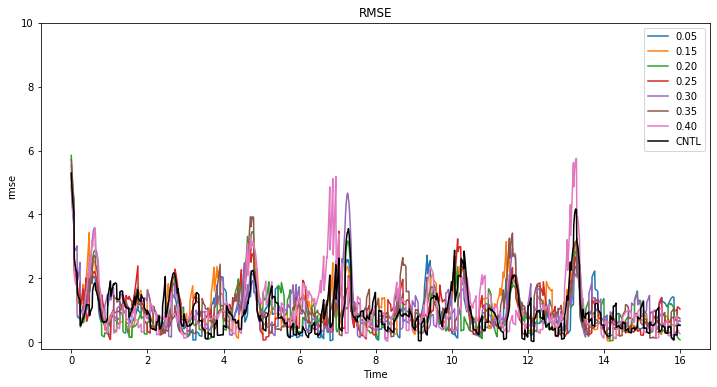

In [13]:
plt.figure(figsize=(12, 6))

mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

for obsm in ex_obs_dict.keys():
    obs = ex_obs_dict[obsm]

    params = {
        'X_ini': X_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'M': lambda X: M(X.ravel(), dt),
        'alpha': 0.3,
        'inflat': 1.4
    }
    ekf = ExtendedKF(lorenz63_fdm, dt)
    ekf.set_params(**params)
    ekf.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(ekf.analysis, X_nature)
    print(
        f'obsm={obsm}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=obsm)
    
plt.plot(ts, rmse_ekf, 'k', label='CNTL')
plt.legend()
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse')
plt.ylim([-0.2, 10]);

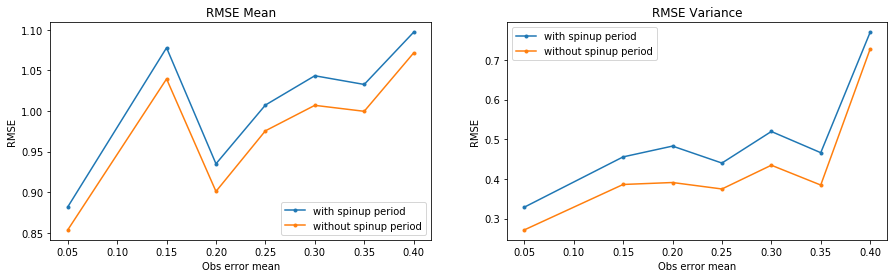

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_mean = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_mean, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_mean, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_mean, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_mean, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Assimilate more extreme bias observations

In [15]:
ex_obs_dict = pickle.load(open('./data/obs_bias_020_520.pickle', 'rb'))

obsm=0.20, Mean RMSE=1.0143, Variance RMSE=0.4703,  Without spinup: Mean RMSE=0.9862, Variance RMSE=0.4029
obsm=0.45, Mean RMSE=1.1217, Variance RMSE=0.7206,  Without spinup: Mean RMSE=1.0953, Variance RMSE=0.6668
obsm=0.70, Mean RMSE=1.3848, Variance RMSE=1.0175,  Without spinup: Mean RMSE=1.3509, Variance RMSE=0.9818
obsm=0.95, Mean RMSE=1.2714, Variance RMSE=0.8174,  Without spinup: Mean RMSE=1.2375, Variance RMSE=0.7592
obsm=1.20, Mean RMSE=1.4512, Variance RMSE=1.0849,  Without spinup: Mean RMSE=1.4155, Variance RMSE=1.0268
obsm=1.45, Mean RMSE=1.6579, Variance RMSE=0.9565,  Without spinup: Mean RMSE=1.6137, Variance RMSE=0.8690
obsm=1.70, Mean RMSE=2.0368, Variance RMSE=1.9261,  Without spinup: Mean RMSE=1.9794, Variance RMSE=1.8412
obsm=1.95, Mean RMSE=2.3133, Variance RMSE=3.1570,  Without spinup: Mean RMSE=2.2153, Variance RMSE=2.8869
obsm=2.20, Mean RMSE=2.3194, Variance RMSE=2.6630,  Without spinup: Mean RMSE=2.2471, Variance RMSE=2.5175
obsm=2.45, Mean RMSE=2.4909, Variance

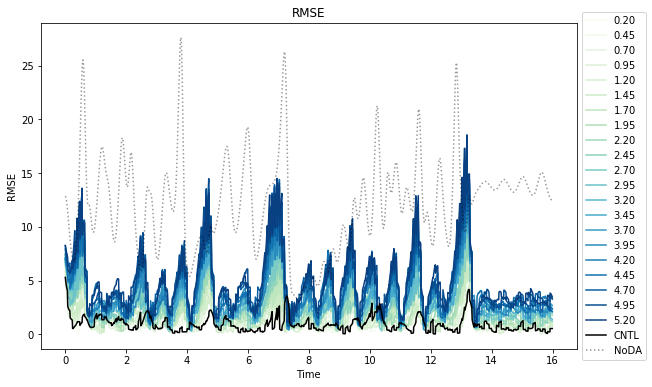

In [16]:
import matplotlib.cm as cm


mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))
colors = cm.GnBu(np.linspace(0, 1, len(ex_obs_dict.keys())))

for obsm, color in zip(ex_obs_dict.keys(), colors):
    obs = ex_obs_dict[obsm]

    params = {
        'X_ini': X_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'M': lambda X: M(X.ravel(), dt),
        'alpha': 0.3,
        'inflat': 1.4
    }
    ekf = ExtendedKF(lorenz63_fdm, dt)
    ekf.set_params(**params)
    ekf.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(ekf.analysis, X_nature)
    print(
        f'obsm={obsm}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())
    
    plt.plot(ts, rmse, color=color, label=obsm)
    
# CNTL
plt.plot(ts, rmse_ekf, color='k', label='CNTL')

# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE');

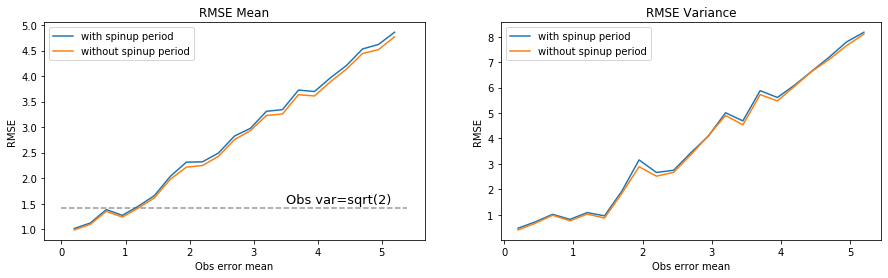

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_mean = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_mean, mean_rmse, label='with spinup period')
axs[0].plot(ex_mean, mean_rmse_nospn, label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')
axs[0].hlines(y=np.sqrt(2), xmin=0, xmax=5.4, ls='dashed', alpha=0.4)
axs[0].text(3.5, np.sqrt(2)+0.1, 'Obs var=sqrt(2)', fontsize=13)

axs[1].plot(ex_mean, var_rmse, label='with spinup period')
axs[1].plot(ex_mean, var_rmse_nospn, label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

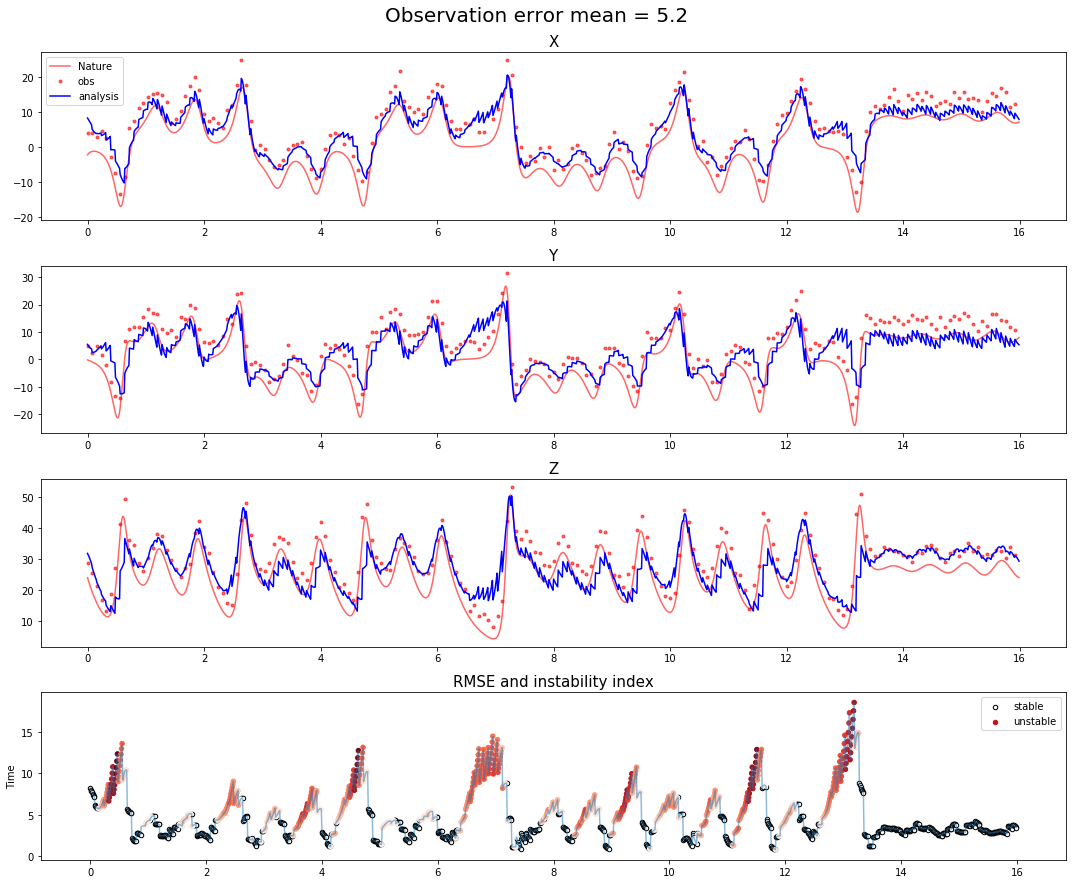

In [63]:
ex_obs_dict = pickle.load(open('./data/obs_bias_020_520.pickle', 'rb'))
obs_bias520 = ex_obs_dict['5.20']

params = {
    'X_ini': X_ini,
    'obs': obs_bias520,
    'obs_interv': 8,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(3),
    'M': lambda X: M(X.ravel(), dt),
    'alpha': 0.3,
    'inflat': 1.4
}
ekf = ExtendedKF(lorenz63_fdm, dt)
ekf.set_params(**params)
ekf.cycle()

fig, axs = plt.subplots(nrows=4, figsize=(15, 12))
for i in range(3):
    axs[i].plot(ts, X_nature[i,:], 'r', alpha=0.6, label='Nature')
    axs[i].plot(ts[::8], obs_bias520[i,:], 'r.', alpha=0.6, label='obs')
    axs[i].plot(ts, ekf.analysis[i,:], 'b', label='analysis')
axs[0].legend()
axs[0].set_title('X', fontsize=15)
axs[1].set_title('Y', fontsize=15)
axs[2].set_title('Z', fontsize=15)

stableidx = []
for xa in ekf.analysis.T:
    stableidx.append(stability_index_lorenz63(*xa))
stableidx = np.array(stableidx)

rmse_bias520 = RMSE(ekf.analysis, X_nature)
axs[3].plot(ts, rmse_bias520, alpha=0.5)

bool_idx = stableidx > 0
axs[3].scatter(ts[~bool_idx], rmse_bias520[~bool_idx], s=20, c='white', edgecolor='k', label='stable')
axs[3].scatter(ts[bool_idx], rmse_bias520[bool_idx], s=20, c=stableidx[bool_idx], cmap='Reds', label='unstable')
axs[3].set_title('RMSE and instability index', fontsize=15)
axs[3].set_ylabel('Time')
legend = axs[3].legend()
legend.legendHandles[1].set_color(plt.cm.Reds(.8))

fig.suptitle('Observation error mean = 5.2', fontsize=20, y=1.02)
plt.tight_layout();

# Third moment

### Assimilate skew observation based on normality test

In [18]:
ex_obs_dict = pickle.load(open('./data/obs_skew_015_135.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.15', '0.45', '0.75', '1.05', '1.35'])

alpha=0.15, Mean RMSE=0.9778, Variance RMSE=0.4645,  Without spinup: Mean RMSE=0.9526, Variance RMSE=0.4153
alpha=0.45, Mean RMSE=1.0318, Variance RMSE=1.0485,  Without spinup: Mean RMSE=1.0085, Variance RMSE=0.9958
alpha=0.75, Mean RMSE=0.9779, Variance RMSE=0.6188,  Without spinup: Mean RMSE=0.9596, Variance RMSE=0.5516
alpha=1.05, Mean RMSE=0.9930, Variance RMSE=0.5113,  Without spinup: Mean RMSE=0.9657, Variance RMSE=0.4753
alpha=1.35, Mean RMSE=0.9279, Variance RMSE=0.5196,  Without spinup: Mean RMSE=0.9062, Variance RMSE=0.4516


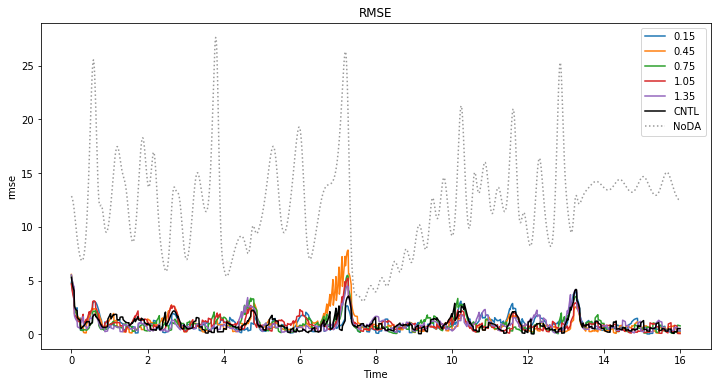

In [19]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_a in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_a]
    
    params = {
        'X_ini': X_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'M': lambda X: M(X.ravel(), dt),
        'alpha': 0.3,
        'inflat': 1.4
    }
    ekf = ExtendedKF(lorenz63_fdm, dt)
    ekf.set_params(**params)
    ekf.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(ekf.analysis, X_nature)
    print(
        f'alpha={ex_a}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_a)
    
# CNTL
plt.plot(ts, rmse_ekf, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
plt.legend()
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

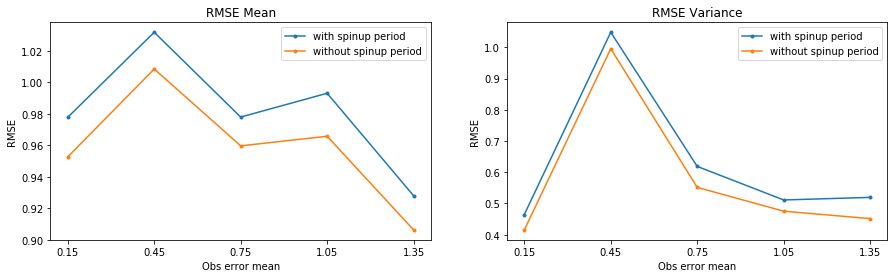

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_alpha = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_alpha, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_alpha, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(ex_alpha)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_alpha, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_alpha, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(ex_alpha)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Assimilate more extreme skewness

In [21]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['1.30', '1.55', '1.80', '2.05', '2.30', '2.55', '2.80', '3.05', '3.30'])

alpha=1.30, Mean RMSE=1.0756, Variance RMSE=0.5373,  Without spinup: Mean RMSE=1.0424, Variance RMSE=0.4643
alpha=1.55, Mean RMSE=0.8701, Variance RMSE=0.4852,  Without spinup: Mean RMSE=0.8479, Variance RMSE=0.3958
alpha=1.80, Mean RMSE=0.9435, Variance RMSE=0.4663,  Without spinup: Mean RMSE=0.9164, Variance RMSE=0.4040
alpha=2.05, Mean RMSE=0.9620, Variance RMSE=0.4736,  Without spinup: Mean RMSE=0.9362, Variance RMSE=0.4089
alpha=2.30, Mean RMSE=1.0121, Variance RMSE=0.5254,  Without spinup: Mean RMSE=0.9691, Variance RMSE=0.4250
alpha=2.55, Mean RMSE=0.9221, Variance RMSE=0.4809,  Without spinup: Mean RMSE=0.9117, Variance RMSE=0.4390
alpha=2.80, Mean RMSE=0.9524, Variance RMSE=0.4355,  Without spinup: Mean RMSE=0.9375, Variance RMSE=0.3858
alpha=3.05, Mean RMSE=0.9839, Variance RMSE=0.4879,  Without spinup: Mean RMSE=0.9656, Variance RMSE=0.4209
alpha=3.30, Mean RMSE=0.8396, Variance RMSE=0.3262,  Without spinup: Mean RMSE=0.8180, Variance RMSE=0.2682


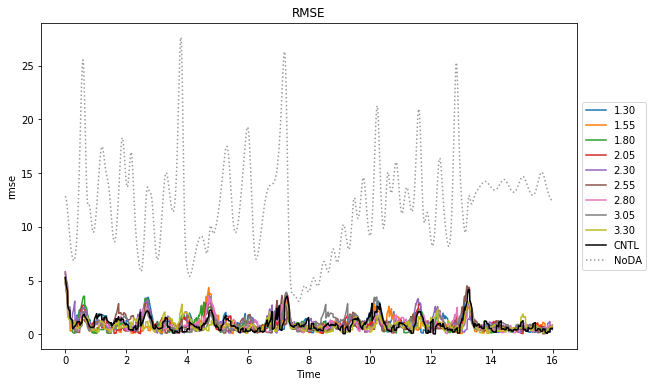

In [22]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_a in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_a]
    
    params = {
        'X_ini': X_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'M': lambda X: M(X.ravel(), dt),
        'alpha': 0.3,
        'inflat': 1.4
    }
    ekf = ExtendedKF(lorenz63_fdm, dt)
    ekf.set_params(**params)
    ekf.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(ekf.analysis, X_nature)
    print(
        f'alpha={ex_a}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_a)
    
# CNTL
plt.plot(ts, rmse_ekf, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

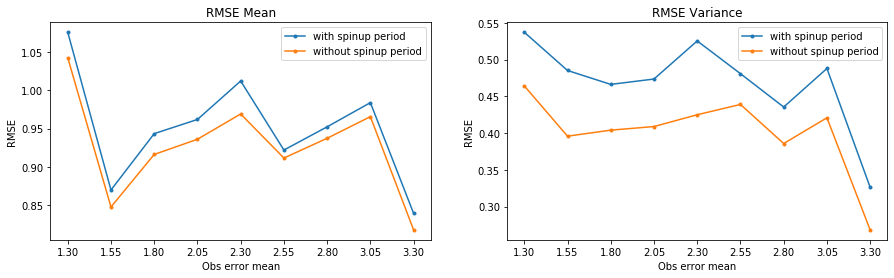

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_alpha = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_alpha, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_alpha, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(ex_alpha)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_alpha, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_alpha, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(ex_alpha)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Repeated assimilate skew observation based on normality test (repeat 10 times)

In [24]:
ex_obs_dict = pickle.load(open('./data/obs_skew_015_135.pickle', 'rb'))
ex_alpha = ex_obs_dict.keys()
ex_alpha = list(map(float, ex_alpha))
ex_alpha

[0.15, 0.45, 0.75, 1.05, 1.35]

In [25]:
from gen_skew_func import gen_skew_obs

rmse_dict = {}
for ex_a in ex_alpha:
    print(ex_a)
    rmse = np.zeros_like(ts)
    
    for _ in range(10):
        obs = gen_skew_obs(mean=0, var=2, alpha=ex_a, obs_intv=8)
        
        params = {
            'X_ini': X_ini,
            'obs': obs,
            'obs_interv': 8,
            'Pb': Pb,
            'R': R,
            'H_func': lambda arr: arr,
            'H': np.eye(3),
            'M': lambda X: M(X.ravel(), dt),
            'alpha': 0.3,
            'inflat': 1.4
        }
        ekf = ExtendedKF(lorenz63_fdm, dt)
        ekf.set_params(**params)
        ekf.cycle()
        rmse += RMSE(ekf.analysis, X_nature)

    rmse /= 10
    key = f'{ex_a:.2f}'
    rmse_dict[key] = rmse

0.15
0.45
0.75
1.05
1.35


alpha = 0.15, mean RMSE = 0.9907
alpha = 0.45, mean RMSE = 0.9721
alpha = 0.75, mean RMSE = 0.9621
alpha = 1.05, mean RMSE = 0.9885
alpha = 1.35, mean RMSE = 0.9878


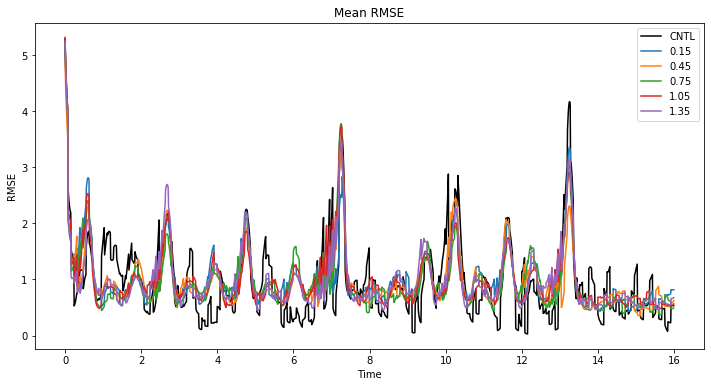

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(ts, rmse_ekf, 'k', label='CNTL')

for key, rmse in rmse_dict.items():
    print(f'alpha = {key}, mean RMSE = {rmse.mean():.4f}')
    plt.plot(ts, rmse, label=key)

plt.legend()
plt.title('Mean RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE');

### Repeated assimilate skew observations for more extreme alpha (repeat 10 times)

In [27]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_alpha = ex_obs_dict.keys()
ex_alpha = list(map(float, ex_alpha))
ex_alpha

[1.3, 1.55, 1.8, 2.05, 2.3, 2.55, 2.8, 3.05, 3.3]

In [28]:
from gen_skew_func import gen_skew_obs

rmse_dict = {}
for ex_a in ex_alpha:
    print(ex_a)
    rmse = np.zeros_like(ts)
    
    for _ in range(10):
        obs = gen_skew_obs(mean=0, var=2, alpha=ex_a, obs_intv=8)
        
        params = {
            'X_ini': X_ini,
            'obs': obs,
            'obs_interv': 8,
            'Pb': Pb,
            'R': R,
            'H_func': lambda arr: arr,
            'H': np.eye(3),
            'M': lambda X: M(X.ravel(), dt),
            'alpha': 0.3,
            'inflat': 1.4
        }
        ekf = ExtendedKF(lorenz63_fdm, dt)
        ekf.set_params(**params)
        ekf.cycle()
        rmse += RMSE(ekf.analysis, X_nature)

    rmse /= 10
    key = f'{ex_a:.2f}'
    rmse_dict[key] = rmse

1.3
1.55
1.8
2.05
2.3
2.55
2.8
3.05
3.3


alpha = 1.30, mean RMSE = 0.9382
alpha = 1.55, mean RMSE = 0.9998
alpha = 1.80, mean RMSE = 0.9843
alpha = 2.05, mean RMSE = 0.9962
alpha = 2.30, mean RMSE = 0.9741
alpha = 2.55, mean RMSE = 0.9769
alpha = 2.80, mean RMSE = 0.9889
alpha = 3.05, mean RMSE = 1.0010
alpha = 3.30, mean RMSE = 0.9862


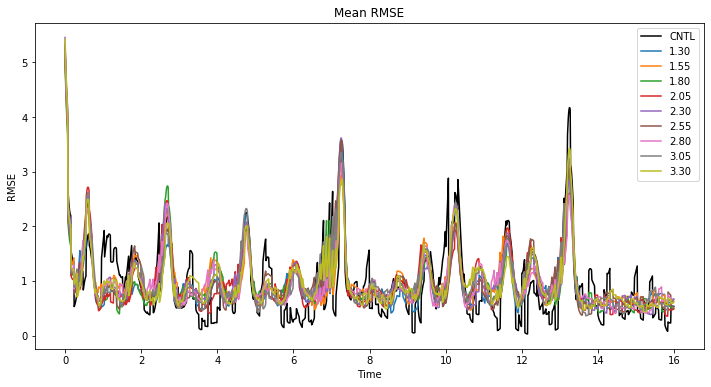

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(ts, rmse_ekf, 'k', label='CNTL')

for key, rmse in rmse_dict.items():
    print(f'alpha = {key}, mean RMSE = {rmse.mean():.4f}')
    plt.plot(ts, rmse, label=key)

plt.legend()
plt.title('Mean RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE');

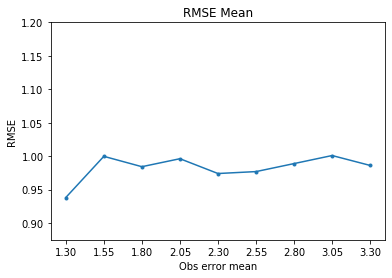

In [31]:
mean_rmse = []
for key, rmse in rmse_dict.items():
    mean_rmse.append(rmse.mean())


plt.plot(ex_alpha, mean_rmse, '.-')
plt.title('RMSE Mean')
plt.xticks(ex_alpha)
plt.xlabel('Obs error mean')
plt.ylabel('RMSE')
plt.ylim([0.875, 1.2]);

### Check the ratio of skew observation located between -2*std ~ 2*std

In [32]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['1.30', '1.55', '1.80', '2.05', '2.30', '2.55', '2.80', '3.05', '3.30'])

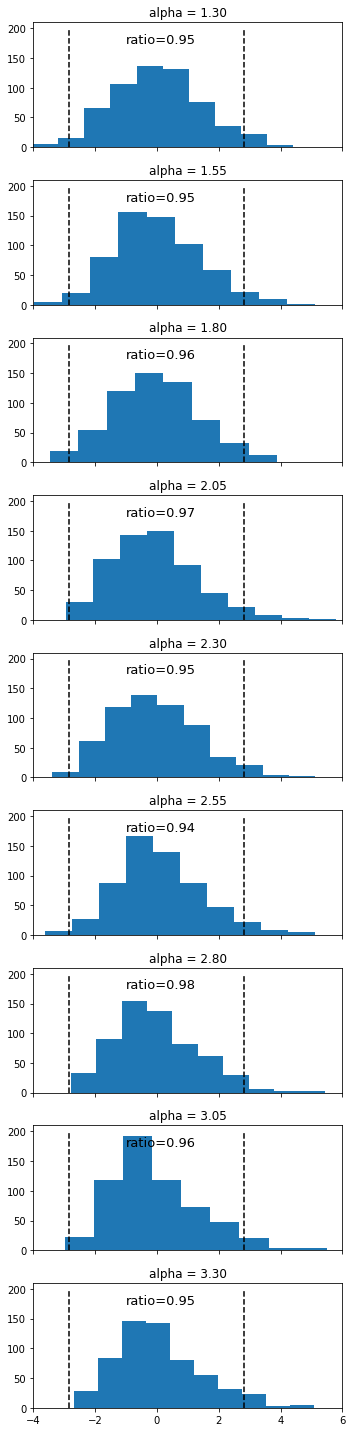

In [33]:
nrows = len(ex_obs_dict.keys())
fig, axs = plt.subplots(nrows=nrows, figsize=(5, 20), sharex=True)

for i, (key, obs) in enumerate(ex_obs_dict.items()):
    obserr = (obs - X_nature[:,::8]).ravel()
    axs[i].hist(obserr)
    
    std = np.sqrt(2)
    axs[i].vlines([2*std, -2*std], ymin=0, ymax=200, ls='dashed')
    axs[i].set_xlim([-4, 6])
    axs[i].set_title(f'alpha = {key}')
    
    total_size = obserr.size
    within_size = obserr[np.where((obserr <= 2*std) & (obserr >= -2*std))].size
    ratio = within_size / total_size
    axs[i].text(-1, 175, f'ratio={ratio:.2f}', fontsize=13)

plt.tight_layout()

# Fourth moment

### Assimilate kurtosis observation based on normality test

In [34]:
ex_obs_dict = pickle.load(open('./data/obs_kurtosis_050_220.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.5', '0.6', '0.7', '0.8', '0.9', '1.2', '1.6', '1.8', '2.0', '2.2'])

delta=0.5, Mean RMSE=1.0535, Variance RMSE=0.5942,  Without spinup: Mean RMSE=1.0136, Variance RMSE=0.5113
delta=0.6, Mean RMSE=0.8914, Variance RMSE=0.3371,  Without spinup: Mean RMSE=0.8689, Variance RMSE=0.2725
delta=0.7, Mean RMSE=0.9911, Variance RMSE=0.4719,  Without spinup: Mean RMSE=0.9602, Variance RMSE=0.3899
delta=0.8, Mean RMSE=0.9769, Variance RMSE=0.4547,  Without spinup: Mean RMSE=0.9568, Variance RMSE=0.3831
delta=0.9, Mean RMSE=0.9786, Variance RMSE=0.4248,  Without spinup: Mean RMSE=0.9499, Variance RMSE=0.3378
delta=1.2, Mean RMSE=1.0462, Variance RMSE=0.7607,  Without spinup: Mean RMSE=1.0285, Variance RMSE=0.7228
delta=1.6, Mean RMSE=0.9458, Variance RMSE=0.3614,  Without spinup: Mean RMSE=0.9164, Variance RMSE=0.2984
delta=1.8, Mean RMSE=1.0639, Variance RMSE=0.5349,  Without spinup: Mean RMSE=1.0412, Variance RMSE=0.4820
delta=2.0, Mean RMSE=0.9147, Variance RMSE=0.3651,  Without spinup: Mean RMSE=0.8983, Variance RMSE=0.3185
delta=2.2, Mean RMSE=0.9844, Variance

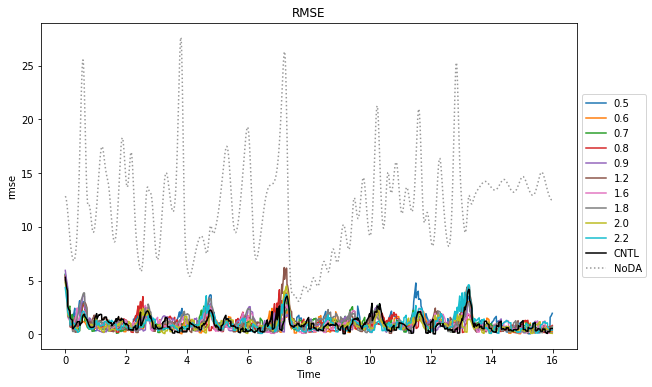

In [35]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_d in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_d]
    
    params = {
        'X_ini': X_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'M': lambda X: M(X.ravel(), dt),
        'alpha': 0.3,
        'inflat': 1.4
    }
    ekf = ExtendedKF(lorenz63_fdm, dt)
    ekf.set_params(**params)
    ekf.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(ekf.analysis, X_nature)
    print(
        f'delta={ex_d}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_d)
    
# CNTL
plt.plot(ts, rmse_ekf, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

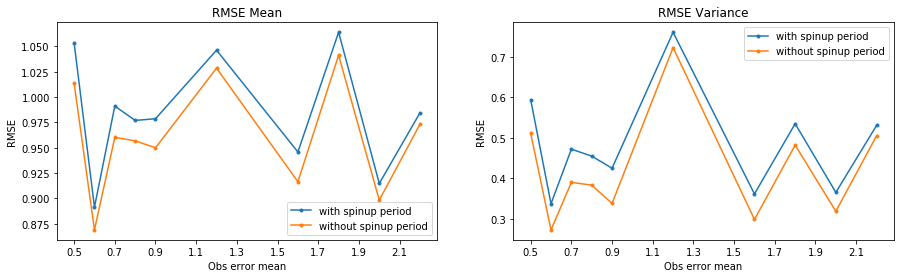

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_delta = list(map(lambda s: float(s), ex_obs_dict.keys()))
xticks = np.arange(min(ex_delta), max(ex_delta), 0.2)

axs[0].plot(ex_delta, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_delta, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(xticks)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_delta, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_delta, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(xticks)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

(-20, 20)

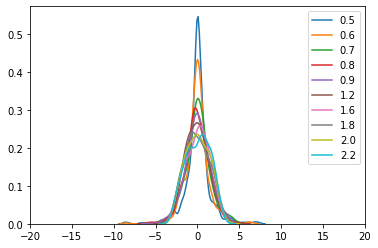

In [37]:
import seaborn as sns

fig, ax = plt.subplots()

for key in ex_obs_dict.keys():
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::8]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
plt.xlim([-20, 20])

### Assimilate kurtosis observation with more extreme delta

In [38]:
ex_obs_dict = pickle.load(open('./data/obs_kurtosis_010_340.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.1', '0.2', '0.3', '0.4', '2.5', '2.8', '3.1', '3.4'])

delta=0.1, Mean RMSE=0.8867, Variance RMSE=1.0949,  Without spinup: Mean RMSE=0.8636, Variance RMSE=1.0568
delta=0.2, Mean RMSE=1.0212, Variance RMSE=1.4200,  Without spinup: Mean RMSE=1.0013, Variance RMSE=1.3930
delta=0.3, Mean RMSE=0.9734, Variance RMSE=0.5849,  Without spinup: Mean RMSE=0.9487, Variance RMSE=0.5321
delta=0.4, Mean RMSE=0.8937, Variance RMSE=0.4273,  Without spinup: Mean RMSE=0.8598, Variance RMSE=0.3494
delta=2.5, Mean RMSE=0.9517, Variance RMSE=0.4681,  Without spinup: Mean RMSE=0.9267, Variance RMSE=0.4016
delta=2.8, Mean RMSE=0.8785, Variance RMSE=0.3662,  Without spinup: Mean RMSE=0.8633, Variance RMSE=0.3335
delta=3.1, Mean RMSE=0.9048, Variance RMSE=0.3907,  Without spinup: Mean RMSE=0.8808, Variance RMSE=0.3515
delta=3.4, Mean RMSE=1.0028, Variance RMSE=0.4979,  Without spinup: Mean RMSE=0.9819, Variance RMSE=0.4570


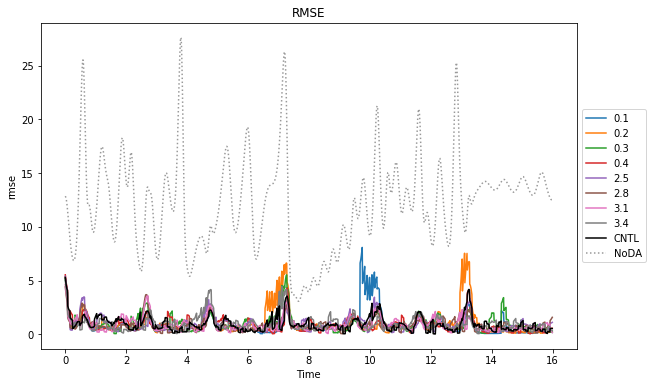

In [39]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_d in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_d]
    
    params = {
        'X_ini': X_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'M': lambda X: M(X.ravel(), dt),
        'alpha': 0.3,
        'inflat': 1.4
    }
    ekf = ExtendedKF(lorenz63_fdm, dt)
    ekf.set_params(**params)
    ekf.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(ekf.analysis, X_nature)
    print(
        f'delta={ex_d}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_d)
    
# CNTL
plt.plot(ts, rmse_ekf, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

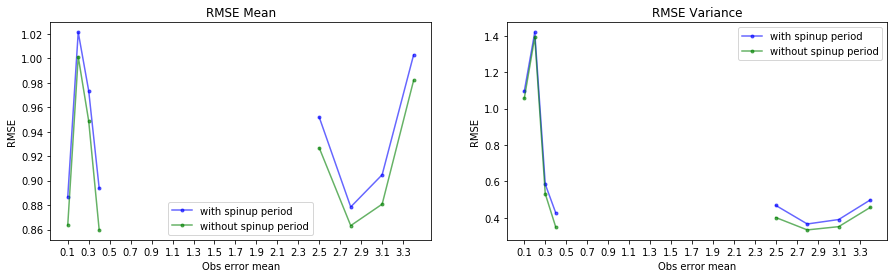

In [40]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_delta = list(map(lambda s: float(s), ex_obs_dict.keys()))
xticks = np.arange(min(ex_delta), max(ex_delta), 0.2)

axs[0].plot(ex_delta[:4], mean_rmse[:4], 'b.-', alpha=0.6, label='with spinup period')
axs[0].plot(ex_delta[4:], mean_rmse[4:], 'b.-', alpha=0.6)
axs[0].plot(ex_delta[:4], mean_rmse_nospn[:4], 'g.-', alpha=0.6, label='without spinup period')
axs[0].plot(ex_delta[4:], mean_rmse_nospn[4:], 'g.-', alpha=0.6)
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(xticks)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_delta[:4], var_rmse[:4], 'b.-', alpha=0.6, label='with spinup period')
axs[1].plot(ex_delta[4:], var_rmse[4:], 'b.-', alpha=0.6)
axs[1].plot(ex_delta[:4], var_rmse_nospn[:4], 'g.-', alpha=0.6, label='without spinup period')
axs[1].plot(ex_delta[4:], var_rmse_nospn[4:], 'g.-', alpha=0.6)
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(xticks)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

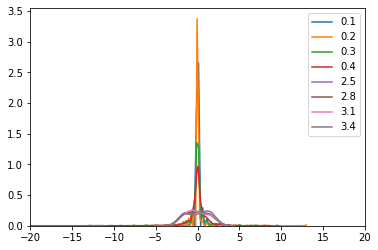

In [41]:
fig, ax = plt.subplots()

for key in ex_obs_dict.keys():
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::8]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
plt.xlim([-20, 20]);